In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import ast
import math
import re
import string

from datasets import Dataset

In [2]:
sns.set_context("paper", font_scale=1.4)
color_palette = sns.color_palette()
sns.set_style("whitegrid", {'font.family': "arial", "font.size": 10})

In [3]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", 
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 
    'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 
    'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 
    'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 
    'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
    'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 
    'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 
    'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 
    'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', 
    "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 
    'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', 
    "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

## Set-up
### Loading datasets

In [4]:
def load_csv_dataset(file_path:str, feature_col:str, target_col:str):
    # Loading dataset
    df = pd.read_csv(file_path, usecols=[feature_col, target_col])
    df.rename(columns={feature_col: "feature", target_col: "target"}, inplace=True)
    df['target'] = df['target'].str.strip().astype('category')
    return df


def load_data(directory_path:str, file_path:str, feature_col:str=None, target_col:str=None,
    top_classes=None, multilabel=None):
    dataset = load_csv_dataset(directory_path + file_path, feature_col, target_col)
    return dataset

In [5]:
with open('../config.json') as f:
        configuration = json.load(f)
data_path = configuration['data']['path']

data = {}
for dataset_name in ['transcriptions', 'ms-cxr']:
    dataset = load_data(data_path, **configuration[dataset_name])
    data[dataset_name] = {'data': dataset}

## Exploring datasets
### General description

------------- DATASET transcriptions-------------

Shape of dataset: (4999, 2)
Number of classes: 40
Statistics per class:
	count      40.00
	mean      124.98
	std       197.67
	min         6.00
	25%        18.75
	50%        57.50
	75%       158.50
	max      1103.00
Number of classes w/ <100 samples: 28 -> 0.2152
Number of classes w/ <50 samples: 18 -> 0.0638

                       target  \
0        Allergy / Immunology   
1                  Bariatrics   
2                  Bariatrics   
3  Cardiovascular / Pulmonary   
4  Cardiovascular / Pulmonary   

                                             feature  
0  SUBJECTIVE:,  This 23-year-old white female pr...  
1  PAST MEDICAL HISTORY:, He has difficulty climb...  
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...  
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...  
4  1.  The left ventricular cavity size and wall ...   



------------- DATASET ms-cxr-------------

Shape of dataset: (1448, 2)
Number of classes: 8
Statistics per class:
	count      8.00
	mean     181.00
	std       88.71
	min       87.00
	25%      105.50
	50%      163.50
	75%      239.25
	max      333.00
Number of classes w/ <100 samples: 2 -> 0.1278
Number of classes w/ <50 samples: 0 -> 0.0

         target                                      feature
0     Pneumonia                          Bibasilar opacities
1     Pneumonia                          Bibasilar opacities
2     Pneumonia  Bilateral multifocal areas of consolidation
3     Pneumonia  Bilateral multifocal areas of consolidation
4  Pneumothorax               Large right-sided pneumothorax 



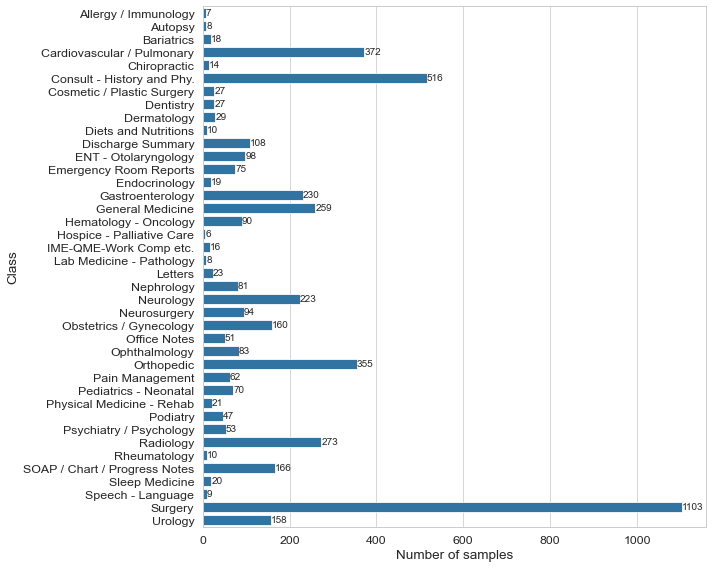

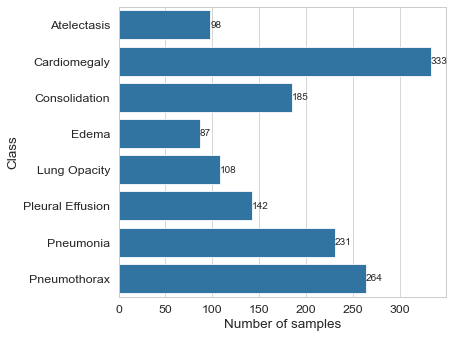

In [6]:
def explore_data(data_dict):
    for key, val in data_dict.items():
        counts = val['data'].target.value_counts()

        # Basic information
        print(
            '------------- DATASET ', key, '-------------\n\n'
            'Shape of dataset: ', val['data'].shape, '\n'
            'Number of classes: ', len(val['data'].target.cat.categories), '\n'
            'Statistics per class:\n\t', re.sub('\n', '\n\t', counts.describe().round(2).to_string()), '\n'
            'Number of classes w/ <100 samples: ', sum(counts < 100), ' -> ', round(sum(counts[counts < 100])/sum(counts), 4), '\n'
            'Number of classes w/ <50 samples: ', sum(counts < 50), ' -> ', round(sum(counts[counts < 50])/sum(counts), 4), '\n',
            sep=''
        )

        # Subset of data
        print(val['data'].head(), '\n')

        # Frequency distribution
        counts = counts.reset_index()
        fig = plt.figure(figsize=(10,8) if key == 'transcriptions' else (6.4, 4.8))
        fig = sns.barplot(data=counts, y='index', x='target', color=color_palette[0])
        for i in fig.containers: fig.bar_label(i, fontsize=10)
        plt.xlabel('Number of samples')
        plt.ylabel('Class')
        plt.tight_layout()
        plt.savefig(f'../../results/plots/{key}__frequency.png', dpi=600)

explore_data(data)

### A. MS-CXR
#### 1. Duplicated and NaN features

In [7]:
dataset = data['ms-cxr']['data']

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   target   1448 non-null   category
 1   feature  1448 non-null   object  
dtypes: category(1), object(1)
memory usage: 13.2+ KB


In [9]:
df_fcounts = pd.DataFrame(np.unique(dataset['feature'], return_counts=True), 
    index=['text', 'count']).T
df_fcounts['pct'] = df_fcounts['count'] / df_fcounts['count'].sum() * 100
print(df_fcounts.sort_values(by='count', ascending=False))

df_agree = dataset.groupby('feature')['target'].agg(lambda x: len(set(x.cat.codes)) == 1)

dup_filter = df_fcounts['count'] > 1
print(
    '\nDuplicated features: {:.1f} ({:.2f}%)'.format(dup_filter.sum(), dup_filter.sum()/dup_filter.shape[0]*100),
    '\nAgreement on labels:', df_agree.all()
)
df_agree[~df_agree]

                                                  text count       pct
364                        enlarged cardiac silhouette    83  5.732044
332                     cardiac silhouette is enlarged    76  5.248619
464                   moderate cardiomegaly is present    22  1.519337
448                                  mild cardiomegaly    20  1.381215
342                                 cardiomegaly noted    17  1.174033
..                                                 ...   ...       ...
279  abnormal opacity in the basilar right hemithor...     1  0.069061
278   a very small left apical pneumothorax is present     1  0.069061
277              a small right pneumothorax is present     1  0.069061
276                  a small right apical pneumothorax     1  0.069061
714      widespread infection, less severe on the left     1  0.069061

[715 rows x 3 columns]

Duplicated features: 306.0 (42.80%) 
Agreement on labels: False


feature
bilateral edema, consolidation, ground-glass opacities              False
diffuse bilateral opacities compatible with consolidation (ards)    False
patchy bibasilar opacities                                          False
Name: target, dtype: bool

In [10]:
dataset[dataset['feature'].isin(df_agree[~df_agree].index)].sort_values('feature')

,target,feature
624,Consolidation,"bilateral edema, consolidation, ground-glass o..."
625,Consolidation,"bilateral edema, consolidation, ground-glass o..."
807,Edema,"bilateral edema, consolidation, ground-glass o..."
808,Edema,"bilateral edema, consolidation, ground-glass o..."
641,Consolidation,diffuse bilateral opacities compatible with co...
642,Consolidation,diffuse bilateral opacities compatible with co...
826,Edema,diffuse bilateral opacities compatible with co...
827,Edema,diffuse bilateral opacities compatible with co...
128,Pneumonia,patchy bibasilar opacities
1199,Lung Opacity,patchy bibasilar opacities


Number of classes: 8
Statistics per class:
	count      8.00
	mean      89.75
	std       50.80
	min       37.00
	25%       51.75
	50%       78.50
	75%      114.50
	max      175.00
Number of classes w/ <100 samples: 5 -> 0.4025
Number of classes w/ <50 samples: 2 -> 0.1058



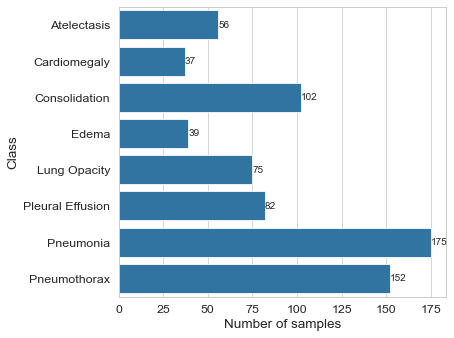

In [11]:
dataset = dataset.drop_duplicates().copy()
counts = dataset.target.value_counts()
print('Number of classes: ', len(dataset.target.cat.categories), '\n'
    'Statistics per class:\n\t', re.sub('\n', '\n\t', counts.describe().round(2).to_string()), '\n'
    'Number of classes w/ <100 samples: ', sum(counts < 100), ' -> ', round(sum(counts[counts < 100])/sum(counts), 4), '\n'
    'Number of classes w/ <50 samples: ', sum(counts < 50), ' -> ', round(sum(counts[counts < 50])/sum(counts), 4), '\n',
    sep=''
)

counts.rename(index={
    'Physical Medicine and Rehabilitation, or Chiropractic': 'Physical Medicine and \nRehabilitation, or Chiropractic', 
    'Laboratory Medicine or Clinical Pathology': 'Laboratory Medicine or \nClinical Pathology'}, 
    inplace=True
)

key = 'ms-cxr'
counts = counts.sort_index().reset_index()
fig = plt.figure(figsize=(10,8) if key == 'transcriptions' else (6.4, 4.8))
fig = sns.barplot(data=counts, y='index', x='target', color=color_palette[0])
for i in fig.containers: fig.bar_label(i, fontsize=10)
plt.xlabel('Number of samples')
plt.ylabel('Class')
plt.tight_layout()
plt.savefig(f'../../results/plots/{key}__frequency.png', dpi=600)

#### 2. Description of features

In [12]:
dataset['char len'] = dataset['feature'].str.len()
dataset['word len'] = dataset['feature'].apply(lambda x: len(x.split()))
dataset['word-char len'] = dataset['feature'].map(lambda x: np.mean([len(word) for word in x.split()]))

In [13]:
dataset.groupby('target')[['char len', 'word len']].describe().round(2)

char len                                                 \
                    count   mean    std   min    25%   50%    75%    max   
target                                                                     
Atelectasis          56.0  61.02  24.96  19.0  41.75  61.5  73.25  113.0   
Cardiomegaly         37.0  31.41  12.33  12.0  23.00  30.0  36.00   76.0   
Consolidation       102.0  63.59  23.23  27.0  44.25  60.0  76.00  129.0   
Edema                39.0  59.95  22.23  15.0  52.50  60.0  68.00  121.0   
Lung Opacity         75.0  56.77  28.06  24.0  40.50  50.0  66.00  191.0   
Pleural Effusion     82.0  53.01  20.82  23.0  40.00  47.0  63.00  138.0   
Pneumonia           175.0  46.81  23.50  18.0  28.00  40.0  65.00  133.0   
Pneumothorax        152.0  35.68  14.64  12.0  27.00  32.0  38.00  113.0   

                 word len                                         
                    count  mean   std  min  25%  50%   75%   max  
target                                                            
Atelectasis          56.0  8.07  3.61  2.0  6.0  8.0  10.0  18.0  
Cardiomegaly         37.0  4.08  1.85  1.0  3.0  4.0   4.0  12.0  
Consolidation       102.0  9.29  4.16  3.0  7.0  8.5  12.0  20.0  
Edema                39.0  7.36  2.84  2.0  6.0  7.0   9.0  15.0  
Lung Opacity         75.0  8.20  4.25  3.0  5.5  7.0   9.0  24.0  
Pleural Effusion     82.0  7.65  3.45  3.0  5.0  7.0   9.0  22.0  
Pneumonia           175.0  6.80  3.66  2.0  4.0  6.0   9.0  19.0  
Pneumothorax        152.0  4.55  2.40  1.0  3.0  4.0   5.0  16.0

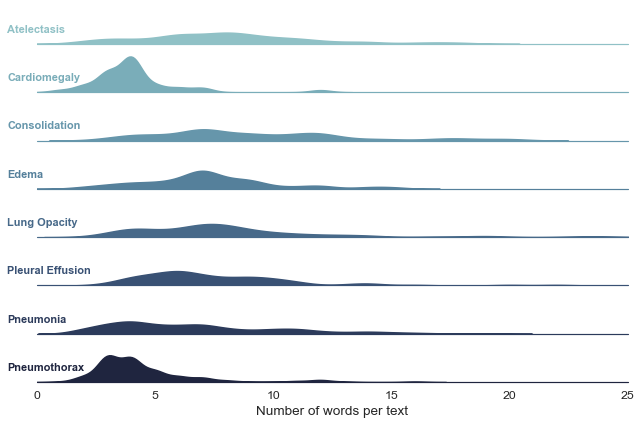

In [22]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.05, 0.4, label, fontweight="bold", ha="left", va="center", color=color, 
      transform=ax.transAxes, size=11)

sns.set_style("white")
pal = sns.cubehelix_palette(len(dataset['target'].unique()), rot=-.25, light=.7)
g = sns.FacetGrid(dataset, row="target", hue="target", aspect=12, height=.75, palette=pal, xlim=(0,25))
g.map(sns.kdeplot, "word len", bw_adjust=.5, clip_on=True, fill=True, alpha=1, linewidth=1.5)
g.map(plt.axhline, y=0, lw=1.2, clip_on=False)
g.map(label, "word len")
g.figure.subplots_adjust(hspace=-.15)
g.set_titles("")
g.set_xlabels("Number of words per text")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.tight_layout()
plt.savefig(f'../../results/plots/ms-cxr__word_frequency.png', dpi=600)
sns.set_style("whitegrid")


#### 3. Label leakage

In [23]:
print('Percentage of features incl. target')
for label in dataset.target.cat.categories:
    aux = dataset.loc[dataset['target'] == label, 'feature']
    print('\tClass:', label, '| Pct:', round(aux.str.lower().str.contains(label.lower()).sum()/aux.shape[0], 4))

Percentage of features incl. target
	Class: Atelectasis | Pct: 0.875
	Class: Cardiomegaly | Pct: 0.4324
	Class: Consolidation | Pct: 0.902
	Class: Edema | Pct: 0.9487
	Class: Lung Opacity | Pct: 0.0133
	Class: Pleural Effusion | Pct: 0.8537
	Class: Pneumonia | Pct: 0.3029
	Class: Pneumothorax | Pct: 0.9671


In [24]:
for label in dataset.target.cat.categories:
    dataset[label] = dataset['feature'].str.lower().str.contains(label.lower())
lhm = dataset.groupby('target')[dataset.target.cat.categories].agg(lambda x: x.sum()/x.shape[0])

In [25]:
lhm

,Atelectasis,Cardiomegaly,Consolidation,Edema,Lung Opacity,Pleural Effusion,Pneumonia,Pneumothorax
target,,,,,,,,
Atelectasis,0.875000,0.000000,0.017857,0.000000,0.000000,0.214286,0.000000,0.000000
Cardiomegaly,0.000000,0.432432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Consolidation,0.009804,0.000000,0.901961,0.039216,0.000000,0.000000,0.009804,0.000000
Edema,0.000000,0.000000,0.128205,0.948718,0.000000,0.000000,0.000000,0.000000
Lung Opacity,0.000000,0.000000,0.013333,0.000000,0.013333,0.000000,0.000000,0.000000
Pleural Effusion,0.000000,0.000000,0.000000,0.012195,0.000000,0.853659,0.000000,0.024390
Pneumonia,0.022857,0.000000,0.240000,0.011429,0.011429,0.000000,0.302857,0.000000
Pneumothorax,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.967105


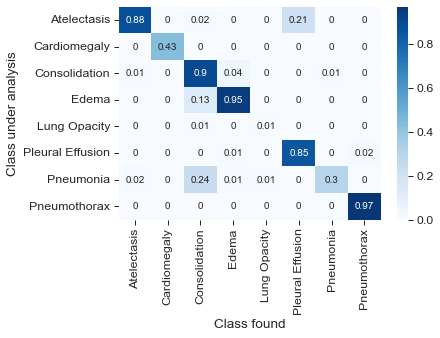

In [26]:
sns.set_style("ticks")
plt.figure(figsize=(6.4, 4.8))
sns.heatmap(lhm.round(2), annot=True, cmap='Blues', center=0.5)
plt.ylabel('Class under analysis')
plt.xlabel('Class found')
plt.tight_layout()
plt.savefig('../../results/plots/ms-cxr__leakage.png', dpi=600)
sns.set_style("whitegrid")


### B. Transcriptions
#### 0. Preprocessing  and NaN features

In [27]:
dataset = data['transcriptions']['data'].copy()

In [28]:
dataset.head()

,target,feature
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   target   4999 non-null   category
 1   feature  4966 non-null   object  
dtypes: category(1), object(1)
memory usage: 45.4+ KB


In [30]:
dataset.dropna(inplace=True)

0.1. Features

In [31]:
idx = 0
print(
    dataset['feature'].iloc[idx], '\n\n\n',
    dataset.loc[idx:(idx+1), 'feature'].str.replace(' +', ' ', regex=True)\
        .str.replace(',(?=[A-z ]+:\s*,)', '\n\n', regex=True)\
        .str.replace(':\s*,\s*', ':\n', regex=True)\
        .str.replace('(?=.\s*),(?=[A-z0-9])' , '\n', regex=True).values.tolist()[0],
    sep=''
)

SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,L

In [32]:
idx = 10
print(
    dataset['feature'].iloc[idx], '\n\n\n',
    dataset.loc[idx:(idx+1), 'feature'].str.replace(' +', ' ', regex=True)\
        .str.replace(',(?=[A-z ]+:\s*,)', '\n\n', regex=True)\
        .str.replace(':\s*,\s*', ':\n', regex=True)\
        .str.replace('(?=.\s*),(?=[A-z0-9])' , '\n', regex=True).values.tolist()[0],
    sep=''
)

PREOPERATIVE DIAGNOSIS: , Morbid obesity. ,POSTOPERATIVE DIAGNOSIS: , Morbid obesity. ,PROCEDURE:,  Laparoscopic Roux-en-Y gastric bypass, antecolic, antegastric with 25-mm EEA anastamosis, esophagogastroduodenoscopy. ,ANESTHESIA: , General with endotracheal intubation. ,INDICATIONS FOR PROCEDURE: , This is a 50-year-old male who has been overweight for many years and has tried multiple different weight loss diets and programs.  The patient has now begun to have comorbidities related to the obesity.  The patient has attended our bariatric seminar and met with our dietician and psychologist.  The patient has read through our comprehensive handout and understands the risks and benefits of bypass surgery as evidenced by the signing of our consent form.,PROCEDURE IN DETAIL: , The risks and benefits were explained to the patient.  Consent was obtained.  The patient was taken to the operating room and placed supine on the operating room table.  General anesthesia was administered with endotr

In [33]:
print(dataset['feature'].iloc[idx])

PREOPERATIVE DIAGNOSIS: , Morbid obesity. ,POSTOPERATIVE DIAGNOSIS: , Morbid obesity. ,PROCEDURE:,  Laparoscopic Roux-en-Y gastric bypass, antecolic, antegastric with 25-mm EEA anastamosis, esophagogastroduodenoscopy. ,ANESTHESIA: , General with endotracheal intubation. ,INDICATIONS FOR PROCEDURE: , This is a 50-year-old male who has been overweight for many years and has tried multiple different weight loss diets and programs.  The patient has now begun to have comorbidities related to the obesity.  The patient has attended our bariatric seminar and met with our dietician and psychologist.  The patient has read through our comprehensive handout and understands the risks and benefits of bypass surgery as evidenced by the signing of our consent form.,PROCEDURE IN DETAIL: , The risks and benefits were explained to the patient.  Consent was obtained.  The patient was taken to the operating room and placed supine on the operating room table.  General anesthesia was administered with endotr

In [34]:
idx = 100
print(
    dataset['feature'].iloc[idx], '\n\n\n',
    dataset.loc[idx:(idx+1), 'feature'].str.replace(' +', ' ', regex=True)\
        .str.replace(',(?=[A-z ]+:\s*,)', '\n\n', regex=True)\
        .str.replace(':\s*,\s*', ':\n', regex=True)\
        .str.replace('(?=.\s*),(?=[A-z0-9])' , '\n', regex=True).values.tolist()[0],
    sep=''
)

PREOPERATIVE DIAGNOSIS:,  Right inguinal hernia.,POSTOPERATIVE DIAGNOSIS:,  Right inguinal hernia.,PROCEDURE:,  Right inguinal hernia repair.,INDICATIONS FOR PROCEDURE: , This patient is a 9-year-old boy with a history of intermittent swelling of the right inguinal area consistent with a right inguinal hernia.  The patient is being taken to the operating room for inguinal hernia repair.,DESCRIPTION OF PROCEDURE: , The patient was taken to the operating room, placed supine, put under general endotracheal anesthesia.  The patient's inguinal and scrotal area were prepped and draped in the usual sterile fashion.  An incision was made in the right inguinal skin crease.  The incision was taken down to the level of the aponeurosis of the external oblique, which was incised up to the level of the external ring.  The hernia sac was verified and dissected at the level of the internal ring and a high ligation performed.  The distal remnant was taken to its end and excised.  The testicle and cord 

In [35]:
idx = 1000
print(
    dataset['feature'].iloc[idx], '\n\n\n',
    dataset.loc[idx:(idx+1), 'feature'].str.replace(' +', ' ', regex=True)\
        .str.replace(',(?=[A-z ]+:\s*,)', '\n\n', regex=True)\
        .str.replace(':\s*,\s*', ':\n', regex=True)\
        .str.replace('(?=.\s*),(?=[A-z0-9])' , '\n', regex=True).values.tolist()[0],
    sep=''
)

INDICATION: ,  Rectal bleeding, constipation, abnormal CT scan, rule out inflammatory bowel disease.,PREMEDICATION: ,See procedure nurse NCS form.,PROCEDURE:  ,


PROCEDURE:
Colonoscopy.

PREOPERATIVE DIAGNOSES:
The patient is a 56-year-old female. She was referred for a screening colonoscopy. The patient has bowel movements every other day. There is no blood in the stool, no abdominal pain. She has hypertension, dyslipidemia, and gastroesophageal reflux disease. She has had cesarean section twice in the past. Physical examination is unremarkable. There is no family history of colon cancer.

POSTOPERATIVE DIAGNOSIS:
Diverticulosis.

PROCEDURE IN DETAIL:
Procedure and possible complications were explained to the patient. Ample opportunity was provided to her to ask questions. Informed consent was obtained. She was placed in left lateral position. Inspection of perianal area was normal. Digital exam of the rectum was normal.
Video Olympus colonoscope was introduced into the rectum. The s

In [36]:
dataset.loc[:, 'feature'] = dataset.loc[:, 'feature'].str.replace(' +', ' ', regex=True)\
    .str.replace(',(?=[A-z ]+:\s*,)', '\n\n', regex=True)\
    .str.replace(':\s*,\s*', ':\n', regex=True)\
    .str.replace('(?=.\s*),(?=[A-z0-9])' , '\n', regex=True).values.tolist()

0.2. Labels

In [37]:
# Proposed labels
labels_norename = [
    'Autopsy', 'Bariatrics', 'Dentistry', 'Dermatology', 'Diets and Nutritions', 
    'Endocrinology', 'Gastroenterology', 'Nephrology', 'Neurology', 'Ophthalmology', 
    'Radiology', 'Sleep Medicine', 'Urology', 'Orthopedic', 'Neurosurgery', 'Podiatry', 
    'Rheumatology', 'Surgery'
]
labels_rename = {
    'Allergy / Immunology': 'Allergy or Immunology',
    'Cardiovascular / Pulmonary': 'Cardiovascular or Pulmonary',
    'Chiropractic': 'Physical Medicine and Rehabilitation, or Chiropractic',
    'Cosmetic / Plastic Surgery': 'Cosmetic or Plastic Surgery',
    'ENT - Otolaryngology': 'Otolaryngology',
    'Hematology - Oncology': 'Hematology or Oncology',
    'Lab Medicine - Pathology': 'Laboratory Medicine or Clinical Pathology',
    'Obstetrics / Gynecology': 'Obstetrics or Gynecology',
    'Pediatrics - Neonatal': 'Pediatrics or Neonatal',
    'Physical Medicine - Rehab': 'Physical Medicine and Rehabilitation, or Chiropractic',
    'Psychiatry / Psychology': 'Psychiatry or Psychology',
    'Speech - Language': 'Speech and Language'
}

In [38]:
dataset = dataset.loc[dataset['target'].isin(labels_norename + list(labels_rename.keys()))]
dataset.loc[:, 'target'] = dataset.loc[:, 'target'].replace(labels_rename).values.tolist()
dataset['target'] = dataset['target'].astype('category')

In [39]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3686 entries, 0 to 4998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   target   3686 non-null   category
 1   feature  3686 non-null   object  
dtypes: category(1), object(1)
memory usage: 62.5+ KB


#### 1. Duplicated

In [40]:
df_fcounts = pd.DataFrame(np.unique(dataset['feature'], return_counts=True), 
    index=['text', 'count']).T
df_fcounts['pct'] = df_fcounts['count'] / df_fcounts['count'].sum() * 100
print(df_fcounts.sort_values(by='count', ascending=False))

df_agree = dataset.groupby('feature')['target'].agg(lambda x: len(set(x.cat.codes)) == 1)

dup_filter = df_fcounts['count'] > 1
print(
    '\nDuplicated features: {:.1f} ({:.2f}%)'.format(dup_filter.sum(), dup_filter.sum()/dup_filter.shape[0]*100),
    '\nAgreement on labels:', df_agree.all()
)
df_agree[~df_agree]

                                                   text count       pct
491   FINDINGS:\nNormal foramen magnum.\nNormal brai...     4  0.108519
818   PREOPERATIVE DIAGNOSES\n1. Adrenal mass, right...     4  0.108519
940   PREOPERATIVE DIAGNOSES:\n1. Mass, left second ...     4  0.108519
868   PREOPERATIVE DIAGNOSES:\n1. Carotid artery occ...     4  0.108519
1710  PROCEDURE:\nSubcutaneous ulnar nerve transposi...     4  0.108519
...                                                 ...   ...       ...
1066  PREOPERATIVE DIAGNOSIS:\n1. Anal cancer.\n2. N...     1   0.02713
1541  PREOPERATIVE DIAGNOSIS:\nSuspicious microcalci...     1   0.02713
1062  PREOPERATIVE DIAGNOSIS (ES):\nRectovaginal fis...     1   0.02713
816   PREOPERATIVE DIAGNOSES\n1. Acute appendicitis....     1   0.02713
239   CHIEF COMPLAINT:\nRight shoulder pain.\n\nHIST...     1   0.02713

[2074 rows x 3 columns]

Duplicated features: 1385.0 (66.78%) 
Agreement on labels: False


feature
1. Odynophagia.\n2. Dysphagia.\n3. Gastroesophageal reflux disease rule out stricture.\n\nPOSTOPERATIVE DIAGNOSES:\n1. Antral gastritis.\n2. Hiatal hernia.\nPROCEDURE PERFORMED: EGD with photos and biopsies.\nGROSS FINDINGS: This is a 75-year-old female who presents with difficulty swallowing, occasional choking, and odynophagia. She has a previous history of hiatal hernia. She was on Prevacid currently. At this time, an EGD was performed to rule out stricture. At the time of EGD, there was noted some antral gastritis and hiatal hernia. There are no strictures, tumors, masses, or varices present.\nOPERATIVE PROCEDURE: The patient was taken to the Endoscopy Suite in the lateral decubitus position. She was given sedation by the Department Of Anesthesia. Once adequate sedation was reached, the Olympus gastroscope was inserted into oropharynx. With air insufflation entered through the proximal esophagus to the GE junction. The esophagus was without evidence of tumors, masses, ulcer

In [41]:
dataset[dataset['feature'].isin(df_agree[~df_agree].index)].sort_values('feature')

,target,feature
874,Surgery,1. Odynophagia.\n2. Dysphagia.\n3. Gastroesoph...
3577,Gastroenterology,1. Odynophagia.\n2. Dysphagia.\n3. Gastroesoph...
110,Urology,1. Pelvic tumor.\n2. Cystocele.\n3. Rectocele....
719,Surgery,1. Pelvic tumor.\n2. Cystocele.\n3. Rectocele....
2598,Obstetrics or Gynecology,1. Pelvic tumor.\n2. Cystocele.\n3. Rectocele....
...,...,...
3193,Hematology or Oncology,XYZ\nRE: ABC\nMEDICAL RECORD#: 123\nDear Dr. X...
1906,Pediatrics or Neonatal,"XYZ, M.D. \nSuite 123, ABC Avenue \nCity, STAT..."
70,Urology,"XYZ, M.D. \nSuite 123, ABC Avenue \nCity, STAT..."
3583,Gastroenterology,"without difficulty, into the upper GI tract. T..."


Number of classes: 29
Statistics per class:
	count      29.00
	mean      127.10
	std       211.82
	min         7.00
	25%        19.00
	50%        53.00
	75%       155.00
	max      1088.00
Number of classes w/ <100 samples: 21 -> 0.2282
Number of classes w/ <50 samples: 14 -> 0.0743



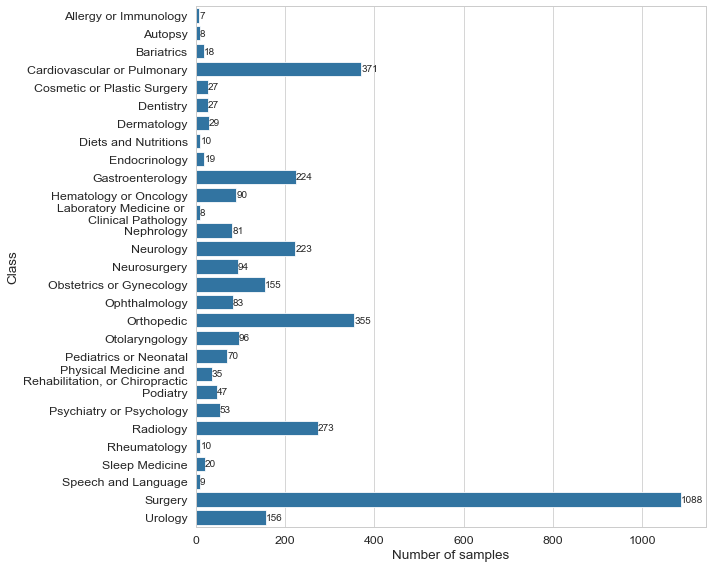

In [34]:
counts = dataset.target.value_counts()
print('Number of classes: ', len(dataset.target.cat.categories), '\n'
    'Statistics per class:\n\t', re.sub('\n', '\n\t', counts.describe().round(2).to_string()), '\n'
    'Number of classes w/ <100 samples: ', sum(counts < 100), ' -> ', round(sum(counts[counts < 100])/sum(counts), 4), '\n'
    'Number of classes w/ <50 samples: ', sum(counts < 50), ' -> ', round(sum(counts[counts < 50])/sum(counts), 4), '\n',
    sep=''
)

counts.rename(index={
    'Physical Medicine and Rehabilitation, or Chiropractic': 'Physical Medicine and \nRehabilitation, or Chiropractic', 
    'Laboratory Medicine or Clinical Pathology': 'Laboratory Medicine or \nClinical Pathology'}, 
    inplace=True
)

key = 'transcriptions'
counts = counts.sort_index().reset_index()
fig = plt.figure(figsize=(10,8) if key == 'transcriptions' else (6.4, 4.8))
fig = sns.barplot(data=counts, y='index', x='target', color=color_palette[0])
for i in fig.containers: fig.bar_label(i,)
plt.xlabel('Number of samples')
plt.ylabel('Class')
plt.tight_layout()
plt.savefig(f'../../results/plots/{key}__frequency.png', dpi=600)

In [42]:
from itertools import product

combination = []
aux = dataset.groupby('feature').target.apply(list).apply(lambda x: list(product(x, x))).values.tolist()
for x in aux:
    combination += x
combination = pd.DataFrame(combination, columns=['x', 'y'], dtype='category')

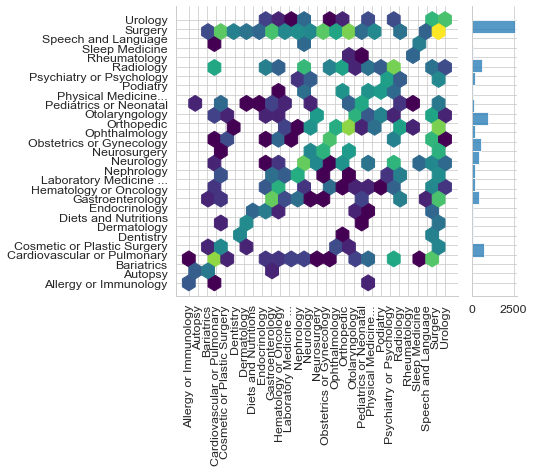

In [43]:
axis_ticks = combination.x.replace({'Physical Medicine and Rehabilitation, or Chiropractic': 'Physical Medicine...', 
    'Laboratory Medicine or Clinical Pathology': 'Laboratory Medicine ...'}).cat.categories.values
g = sns.jointplot(x=combination.x.cat.codes, y=combination.y.cat.codes, cmap='viridis', kind='hex',
    bins='log', height=7.5, marginal_ticks=True) 
g.ax_joint.set_xticks(range(len(combination.x.cat.categories.values)), axis_ticks);
g.ax_joint.set_yticks(range(len(combination.y.cat.categories.values)), axis_ticks);
g.ax_joint.tick_params(axis="x", rotation=90)
g.ax_marg_x.remove()
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig(f'../../results/plots/transcriptions__mutual_frequency.png', dpi=600)

#### 2. Description of features

In [44]:
dataset['char len'] = dataset['feature'].str.len()
dataset['word len'] = dataset['feature'].apply(lambda x: len(x.split()))
dataset['word-char len'] = dataset['feature'].map(lambda x: np.mean([len(word) for word in x.split()]))

In [45]:
dataset.groupby('target')[['char len', 'word len']].describe().round(2)

char len                    \
                                                      count     mean      std   
target                                                                          
Allergy or Immunology                                   7.0  2964.86  1717.88   
Autopsy                                                 8.0  7510.25  3801.71   
Bariatrics                                             18.0  2506.00  1219.59   
Cardiovascular or Pulmonary                           371.0  2884.58  1891.30   
Cosmetic or Plastic Surgery                            27.0  3540.44  1675.62   
Dentistry                                              27.0  3252.44  1230.60   
Dermatology                                            29.0  2572.28  2751.66   
Diets and Nutritions                                   10.0  2358.80  1160.07   
Endocrinology                                          19.0  4122.21  1632.76   
Gastroenterology                                      224.0  2362.85  1440.58   
Hematology or Oncology                                 90.0  2647.17  1672.13   
Laboratory Medicine or Clinical Pathology               8.0  1541.00   749.43   
Nephrology                                             81.0  2817.56  1665.77   
Neurology                                             223.0  3223.16  2120.94   
Neurosurgery                                           94.0  3686.85  1819.08   
Obstetrics or Gynecology                              155.0  3052.79  1821.93   
Ophthalmology                                          83.0  2359.93  1302.23   
Orthopedic                                            355.0  3603.04  2234.88   
Otolaryngology                                         96.0  2857.46  1724.13   
Pediatrics or Neonatal                                 70.0  2880.96  1408.22   
Physical Medicine and Rehabilitation, or Chirop...     35.0  4074.23  3702.78   
Podiatry                                               47.0  3032.19  2138.99   
Psychiatry or Psychology                               53.0  5069.30  3057.63   
Radiology                                             273.0  1875.71  1249.37   
Rheumatology                                           10.0  3096.00  1170.81   
Sleep Medicine                                         20.0  1926.10  1684.51   
Speech and Language                                     9.0  2657.11  1418.18   
Surgery                                              1088.0  3140.30  1921.75   
Urology                                               156.0  2607.64  1809.97   

                                                                             \
                                                       min      25%     50%   
target                                                                        
Allergy or Immunology                               1097.0  1429.00  2739.0   
Autopsy                                               44.0  5462.00  9145.5   
Bariatrics                                          1024.0  1550.25  1986.5   
Cardiovascular or Pulmonary                           13.0  1413.00  2468.0   
Cosmetic or Plastic Surgery                          741.0  2093.50  3718.0   
Dentistry                                           1100.0  2338.50  2825.0   
Dermatology                                          590.0  1336.00  1667.0   
Diets and Nutritions                                 882.0  1215.00  2567.5   
Endocrinology                                       1389.0  2858.00  3734.0   
Gastroenterology                                      12.0  1343.00  2015.5   
Hematology or Oncology                               711.0  1492.75  2193.0   
Laboratory Medicine or Clinical Pathology            510.0  1148.00  1529.0   
Nephrology                                           111.0  1719.00  2483.0   
Neurology                                            152.0  1833.50  2823.0   
Neurosurgery                                         688.0  2440.75  3191.5   
Obstetrics or Gynecology            

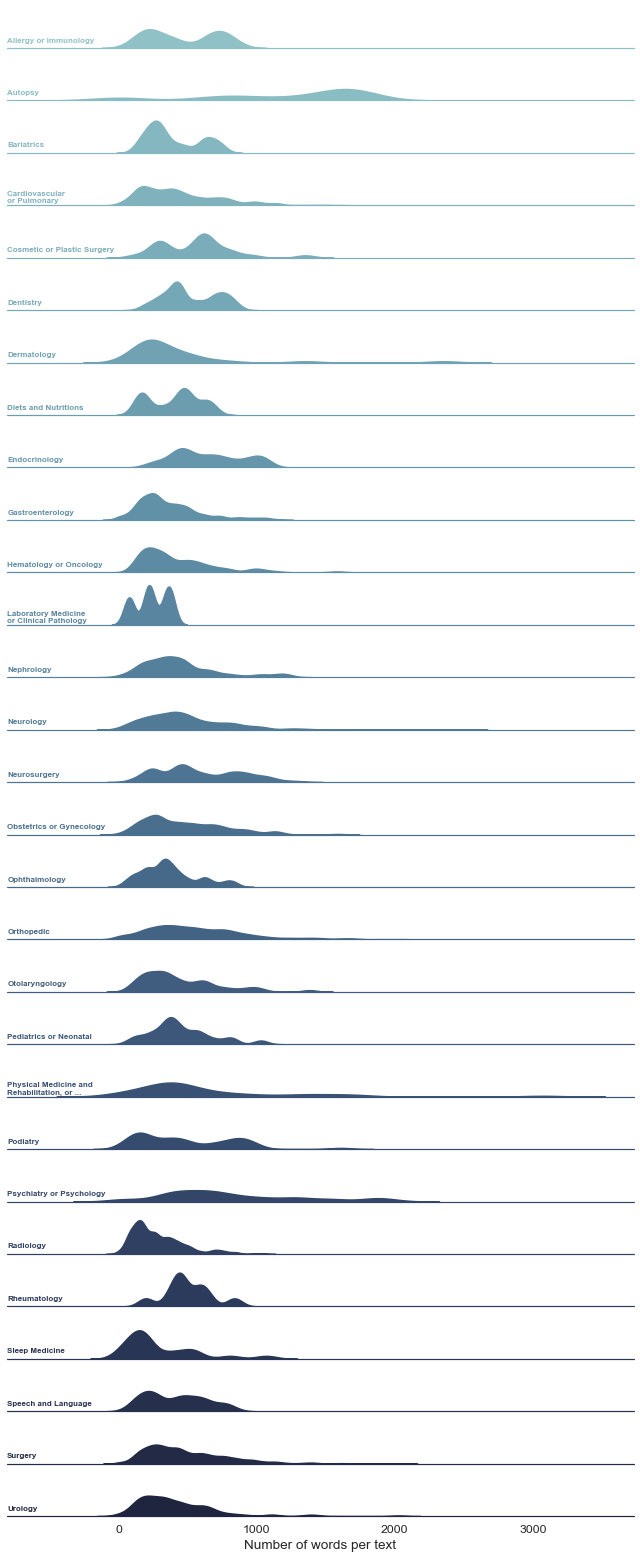

In [49]:
def label(x, color, label):
    ax = plt.gca()
    match label:
      case 'Physical Medicine and Rehabilitation, or Chiropractic':
        label = 'Physical Medicine and\nRehabilitation, or ...'
      case 'Laboratory Medicine or Clinical Pathology':
        label = 'Laboratory Medicine\nor Clinical Pathology'
      case 'Cardiovascular or Pulmonary':
        label = 'Cardiovascular \nor Pulmonary'
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", 
      transform=ax.transAxes, size=8)

sns.set_style("white")
pal = sns.cubehelix_palette(len(dataset['target'].unique()), rot=-.25, light=.7)
g = sns.FacetGrid(dataset, row="target", hue="target", aspect=12, height=.75, palette=pal)
g.map(sns.kdeplot, "word len", bw_adjust=.5, clip_on=True, fill=True, alpha=1, linewidth=1.5)
g.map(plt.axhline, y=0, lw=1.2, clip_on=False)
g.map(label, "word len")
g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set_xlabels("Number of words per text")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.tight_layout()
plt.savefig(f'../../results/plots/transcriptions__word_frequency.png', dpi=600)
sns.set_style('whitegrid')


#### 3. Label leakage

In [40]:
print('Percentage of features incl. target')
for label in dataset.target.cat.categories:
    aux = dataset.loc[dataset['target'] == label, 'feature']
    print('\tClass:', label, '| Pct:', round(aux.str.lower().str.contains(label.lower()).sum()/aux.shape[0], 4))

Percentage of features incl. target
	Class: Allergy or Immunology | Pct: 0.0
	Class: Autopsy | Pct: 0.625
	Class: Bariatrics | Pct: 0.0556
	Class: Cardiovascular or Pulmonary | Pct: 0.0
	Class: Cosmetic or Plastic Surgery | Pct: 0.0
	Class: Dentistry | Pct: 0.037
	Class: Dermatology | Pct: 0.1724
	Class: Diets and Nutritions | Pct: 0.0
	Class: Endocrinology | Pct: 0.1053
	Class: Gastroenterology | Pct: 0.0089
	Class: Hematology or Oncology | Pct: 0.0
	Class: Laboratory Medicine or Clinical Pathology | Pct: 0.0
	Class: Nephrology | Pct: 0.0617
	Class: Neurology | Pct: 0.1031
	Class: Neurosurgery | Pct: 0.0426
	Class: Obstetrics or Gynecology | Pct: 0.0
	Class: Ophthalmology | Pct: 0.012
	Class: Orthopedic | Pct: 0.0789
	Class: Otolaryngology | Pct: 0.0208
	Class: Pediatrics or Neonatal | Pct: 0.0
	Class: Physical Medicine and Rehabilitation, or Chiropractic | Pct: 0.0
	Class: Podiatry | Pct: 0.0851
	Class: Psychiatry or Psychology | Pct: 0.0
	Class: Radiology | Pct: 0.0147
	Class: Rheum

In [41]:
for label in dataset.target.cat.categories:
    dataset[label] = dataset['feature'].str.lower().str.contains(label.lower())
lhm = dataset.groupby('target')[dataset.target.cat.categories].agg(lambda x: x.sum()/x.shape[0])

In [42]:
to_rename = {
    'Physical Medicine and Rehabilitation, or Chiropractic': 'Physical Medicine and\nRehabilitation, or Chiropractic',
    'Laboratory Medicine or Clinical Pathology': 'Laboratory Medicine\nor Clinical Pathology'
}
lhm.rename(index=to_rename, columns=to_rename, inplace=True)

In [43]:
lhm = lhm.apply(lambda x: x[x.name]).reset_index()
lhm.columns = ['label', 'pct']
lhm['pct'] *= 100

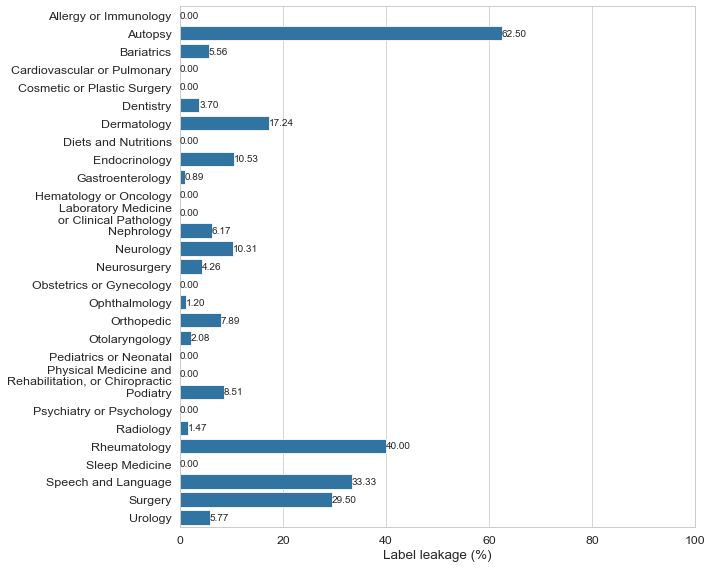

In [44]:
plt.figure(figsize=(10,8))
ax = sns.barplot(lhm.round(2), x='pct', y='label')
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
plt.xlim(0,100)
plt.xlabel('Label leakage (%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('../../results/plots/transcriptions__leakage.png', dpi=600)

### C. MIMIC-CXR
#### 0. Preprocessing  and NaN features

In [45]:
dataset = pd.read_csv('../../data/mimic_cxr.csv')

In [46]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78584 entries, 0 to 78583
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  78584 non-null  object
 1   section    75060 non-null  object
 2   text       75029 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [47]:
dataset.dropna(subset='text', inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75029 entries, 0 to 78583
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  75029 non-null  object
 1   section    75029 non-null  object
 2   text       75029 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


#### 1. Duplicated

In [48]:
df_fcounts = pd.DataFrame(np.unique(dataset['text'], return_counts=True), index=['text', 'count']).T
df_fcounts['pct'] = df_fcounts['count'] / df_fcounts['count'].sum() * 100
print(df_fcounts.sort_values(by='count', ascending=False))

dup_filter = df_fcounts['count'] > 1
print(
    '\nDuplicated features: {:.1f} ({:.2f}%)'.format(dup_filter.sum(), dup_filter.sum()/dup_filter.shape[0]*100),
)

                                                    text count       pct
40146                  No acute cardiopulmonary process.  5912   7.87962
41061                    No acute intrathoracic process.  1635  2.179157
39766              No acute cardiopulmonary abnormality.  1614  2.151168
41988      No evidence of acute cardiopulmonary process.   458  0.610431
42371                          No evidence of pneumonia.   456  0.607765
...                                                  ...   ...       ...
19285  Comparison to ___. No relevant change is noted...     1  0.001333
19286  Comparison to ___. No relevant change is noted...     1  0.001333
19287  Comparison to ___. No relevant change is noted...     1  0.001333
19288  Comparison to ___. No relevant change is noted...     1  0.001333
57721  volumes are low and there is crowding at both ...     1  0.001333

[57722 rows x 3 columns]

Duplicated features: 977.0 (1.69%)


In [49]:
df_fcounts.loc[df_fcounts['count'] > 1, ['pct', 'count']].astype(float).describe()

,pct,count
count,977.000000,977.000000
mean,0.024943,18.714432
std,0.273350,205.091921
min,0.002666,2.000000
25%,0.002666,2.000000
50%,0.003998,3.000000
75%,0.006664,5.000000
max,7.879620,5912.000000


#### 2. Description of features

2.0. Preprocessing

Analysis of texts with lengths smaller than 2 words

In [50]:
df_fcounts[df_fcounts['text'].isin(dataset[dataset['text'].apply(lambda x: len(x.split())) == 1]\
    ['text'].drop_duplicates().values.tolist())]

,text,count,pct
2,.,1,0.001333
15458,CHF,3,0.003998
15476,CHF.,3,0.003998
15531,COPD,1,0.001333
15552,COPD.,2,0.002666
16284,Cardiomegaly.,5,0.006664
44688,None.,2,0.002666
44985,Normal.,16,0.021325
56880,Unchanged.,1,0.001333
57426,___,1,0.001333


In [51]:
dataset[dataset['text'].apply(lambda x: len(x.split())) == 2]\
    ['text'].drop_duplicates().values.tolist()

['No pneumonia.',
 'Normal chest.',
 'Stable exam',
 'Lungs clear.',
 'As above.',
 'No change.',
 'Limited, negative.',
 'As above',
 'No pneumothorax.',
 'As above..',
 'Stable cardiomegaly.',
 'Stable examination.',
 'BILATERAL PNEUMONIA.',
 'Clear lungs.',
 'UNCHANGED pneumomediastinum.',
 'No pneumonia',
 'No pneumothorax',
 'Mild CHF.',
 'Unremarkable study.',
 'Resolving hydropneumothorax.',
 'Normal exam.',
 'No infiltrate',
 'Mild improvement',
 'Pneumoperitoneum persists.',
 'increased CHF',
 'No infiltrate.',
 'Mild cardiomegaly.',
 'Status quo.',
 'Little change.',
 'Multifocal pneumonia.',
 'Probable pneumonia.',
 'Pulmonary edema.',
 'Bibasilar atelectasis.',
 'No change',
 'Lingular pneumonia.',
 'No infiltrates',
 'Limited negative.',
 'Resolved pneumonia.',
 'See above.',
 'Diminishing pneumothorax.',
 'Left pneumothorax.',
 'Worsening pneumonia.',
 'Right pneumothorax.',
 'No pneumomediastinum.',
 'Hyperinflated lungs.',
 'Normal radiograph.',
 'Bibasilar atelectasis'

In [52]:
df_fcounts[df_fcounts['text'].isin(['No change.', 'As above.', 'Stable exam', 'As above..', 
  'Limited, negative.', 'As above', 'Status quo.', 'Stable examination.', 'Little change.',
  'See above.', 'Unremarkable study.', 'Mild improvement', 'Some improvement.', 'Stable exam.',
  'No change', 'Limited negative.', 'Increasing failure.', 'Interval improvement', 
  'Unremarkable exam.', 'Interval worsening.', 'Status quo', 'Unremarkable radiograph.',
  'Limited, normal.', 'Little change', 'AS ABOVE', '___ earlier', 'AS ABOVE..', 'AS ABOVE.'])]

,text,count,pct
8901,As above,13,0.017327
8902,As above.,157,0.209252
8908,As above..,10,0.013328
31063,Increasing failure.,1,0.001333
32383,Interval worsening.,4,0.005331
33882,Limited negative.,3,0.003998
33937,"Limited, negative.",32,0.04265
34086,Little change.,13,0.017327
36027,Mild improvement,1,0.001333
41343,No change,12,0.015994


*After analysing the sentences, the following will be excluded: '.', 'S', '\_\_\_', '\_\_\_,', 'On', '___.',
'Stop', 'As above.', 'As above..', 'Slight', 'Failure.'*

In [53]:
df_fcounts[df_fcounts['text'].isin(['.', 'S', '___', '___,', 'None.', 'On', 'Improvement.', '___.',
    'Unchanged.', 'Stop', 'Unremarkable.', 'Slight', 'Failure.', '___ earlier', 'AS ABOVE', 
    'AS ABOVE.', 'AS ABOVE..', 'As above', 'As above.', 'As above..', 'See above.'])]

,text,count,pct
2,.,1,0.001333
8901,As above,13,0.017327
8902,As above.,157,0.209252
8908,As above..,10,0.013328
44688,None.,2,0.002666
49979,See above.,3,0.003998
56880,Unchanged.,1,0.001333
57426,___,1,0.001333
57467,___ earlier,1,0.001333
57497,"___,",1,0.001333


In [54]:
print('Percentage of discarded samples: ', df_fcounts[df_fcounts['text'].isin(
    ['.', 'S', '___', '___,', 'None.', 'On', 'Improvement.', '___.', 'Unchanged.', 'Stop', 
    'Unremarkable.', 'Slight', 'Failure.', '___ earlier', 'AS ABOVE', 'AS ABOVE.', 'AS ABOVE..', 
    'As above', 'As above.', 'As above..', 'See above.'])].pct.sum().round(4), '%', sep='')

dataset = dataset[~dataset['text'].isin(['.', 'S', '___', '___,', 'None.', 'On', 'Improvement.', '___.',
    'Unchanged.', 'Stop', 'Unremarkable.', 'Slight', 'Failure.', '___ earlier', 'AS ABOVE', 
    'AS ABOVE.', 'AS ABOVE..', 'As above', 'As above.', 'As above..', 'See above.'])]

Percentage of discarded samples: 0.2599%


In [55]:
dataset.drop_duplicates(subset='text', inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57711 entries, 0 to 78582
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  57711 non-null  object
 1   section    57711 non-null  object
 2   text       57711 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [56]:
dataset.section.value_counts()

impression    47274
findings      10090
comparison      326
special          13
misnamed          8
Name: section, dtype: int64

2.1. Distribution of word

In [57]:
dataset['char len'] = dataset['text'].str.len()
dataset['word len'] = dataset['text'].apply(lambda x: len(x.split()))
dataset['word-char len'] = dataset['text'].map(lambda x: np.mean([len(word) for word in x.split()]))

In [58]:
dataset[['char len', 'word len']].describe()

,char len,word len
count,57711.000000,57711.000000
mean,248.168876,37.104036
std,163.225449,25.413860
min,3.000000,1.000000
25%,117.000000,17.000000
50%,224.000000,33.000000
75%,340.000000,51.000000
max,2050.000000,307.000000


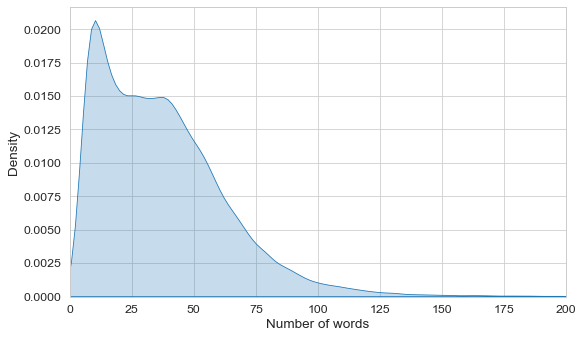

In [59]:
plt.figure(figsize=(8.2, 4.8))
g = sns.kdeplot(dataset, x='word len', fill=True)
g.set_xlim(0,200)
plt.xlabel('Number of words')
plt.tight_layout()
plt.savefig('../../results/plots/mimic-cxr__word_frequency.png', dpi=600)
